In [127]:
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import TimeSeriesSplit, train_test_split
# from tf.keras.models import Sequential # This does not work!
from tensorflow.python.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, GRU, Embedding
from tensorflow.keras.optimizers import RMSprop
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau

In [128]:
from sklearn.preprocessing import MinMaxScaler
df = pd.read_csv("../data/datefrom1st.csv")
df.index = df.datetime
df = df.drop(["Unnamed: 0",'datetime'], axis = 1)

In [129]:
def multivariate_data(ds, target, start_index, end_index, history_size, target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(ds) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(ds[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [130]:
BUFFER_SIZE = 10000
BATCH_SIZE = 256
TEST_RATIO = 0.3
TRAIN_SIZE = int((1-TEST_RATIO)*df.shape[0])

In [131]:
df.head(5)


,result,temperature,percipitation,wind_degree,wind_speed,air_pressure,sea_level_pressure,humidity,solar_radiation,solar_intensity,difference
datetime,,,,,,,,,,,
2019-07-01 00:00:00,0.0,23.273333,0.0,216.073333,1.193333,997.380000,1003.880000,84.453333,0.0,0.0,181.000000
2019-07-01 00:15:00,0.0,23.200000,0.0,225.486667,1.306667,997.266667,1003.766667,84.853333,0.0,0.0,181.010417
2019-07-01 00:30:00,0.0,23.200000,0.0,223.140000,0.646667,997.200000,1003.700000,85.280000,0.0,0.0,181.020833
2019-07-01 00:45:00,0.0,23.200000,0.0,252.066667,1.053333,997.200000,1003.700000,85.560000,0.0,0.0,181.031250
2019-07-01 01:00:00,0.0,23.200000,0.0,230.933333,0.973333,997.133333,1003.633333,85.740000,0.0,0.0,181.041667


In [132]:
shift_days = 1
shift_steps = shift_days * 24 * 4
df_targets = df.result.shift(-shift_steps)

In [133]:
# X_train, X_test, y_train, y_test = train_test_split(dataset[:,1:], dataset[:,0], test_size=0.20, shuffle=False)
# 

In [134]:
df.head(15)

,result,temperature,percipitation,wind_degree,wind_speed,air_pressure,sea_level_pressure,humidity,solar_radiation,solar_intensity,difference
datetime,,,,,,,,,,,
2019-07-01 00:00:00,0.0,23.273333,0.0,216.073333,1.193333,997.380000,1003.880000,84.453333,0.0,0.0,181.000000
2019-07-01 00:15:00,0.0,23.200000,0.0,225.486667,1.306667,997.266667,1003.766667,84.853333,0.0,0.0,181.010417
2019-07-01 00:30:00,0.0,23.200000,0.0,223.140000,0.646667,997.200000,1003.700000,85.280000,0.0,0.0,181.020833
2019-07-01 00:45:00,0.0,23.200000,0.0,252.066667,1.053333,997.200000,1003.700000,85.560000,0.0,0.0,181.031250
2019-07-01 01:00:00,0.0,23.200000,0.0,230.933333,0.973333,997.133333,1003.633333,85.740000,0.0,0.0,181.041667
2019-07-01 01:15:00,0.0,23.140000,0.0,218.113333,0.900000,997.026667,1003.526667,85.893333,0.0,0.0,181.052083
2019-07-01 01:30:00,0.0,23.133333,0.0,255.533333,1.366667,997.160000,1003.660000,86.080000,0.0,0.0,181.062500
2019-07-01 01:45:00,0.0,23.133333,0.0,251.833333,0.940000,997.080000,1003.580000,86.186667,0.0,0.0,181.072917
2019-07-01 02:00:00,0.0,23.100000,0.0,248.373333,1.360000,996.966667,1003.466667,86.146667,0.0,0.0,181.083333


In [135]:
x_data = df.values[0:-shift_steps]
print(type(x_data))
print("Shape:", x_data.shape)

<class 'numpy.ndarray'>
Shape: (35041, 11)


In [136]:
y_data = df_targets.values[:-shift_steps]
print(type(y_data))
print("Shape:", y_data.shape)
    

<class 'numpy.ndarray'>
Shape: (35041,)


In [137]:
num_data = len(x_data)
train_split = 0.9
num_train = int(train_split * num_data)
num_test = num_data - num_train
x_train = x_data[0:num_train]
x_test = x_data[num_train:]
y_train = y_data[0:num_train]
y_test = y_data[num_train:]
num_x_signals = x_data.shape[1]
num_y_signals = 1

In [138]:
x_scaler = MinMaxScaler()
x_train_scaled = x_scaler.fit_transform(x_train)
print("Min:", np.min(x_train_scaled))
print("Max:", np.max(x_train_scaled))

Min: 0.0
Max: 1.0


In [139]:
x_test_scaled = x_scaler.transform(x_test)
y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1, 1))
y_test_scaled = y_scaler.transform(y_test.reshape(-1, 1))

In [140]:
print(x_train_scaled.shape)
print(y_train_scaled.shape)

(31536, 11)
(31536, 1)


In [141]:
def batch_generator(batch_size, sequence_length):
    """
    Generator function for creating random batches of training-data.
    """
    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, sequence_length, num_x_signals)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)
        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, sequence_length, num_y_signals)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)
        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(num_train - sequence_length)
            
            # Copy the sequences of data starting at this index.
            x_batch[i] = x_train_scaled[idx:idx+sequence_length]
            y_batch[i] = y_train_scaled[idx:idx+sequence_length]

        yield (x_batch, y_batch)

In [142]:
batch_size = 256
sequence_length = 24 * 7 * 4 * 4

In [143]:
generator = batch_generator(batch_size=batch_size,
 sequence_length=sequence_length)

In [144]:
x_batch, y_batch = next(generator)

In [145]:
print(x_batch.shape)
print(y_batch.shape)

(256, 2688, 11)
(256, 2688, 1)


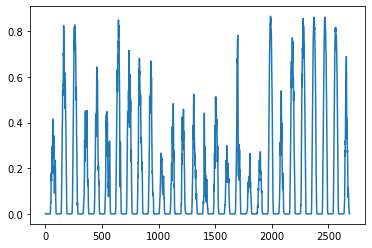

In [146]:
batch = 0 # First sequence in the batch.
signal = 0 # First signal from the 20 input-signals.
seq = x_batch[batch, :, signal]
plt.plot(seq)

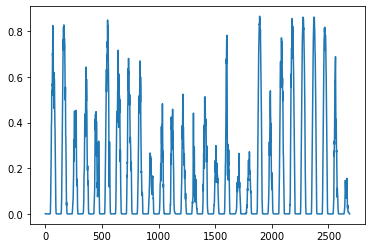

In [147]:
seq = y_batch[batch, :, signal]
plt.plot(seq)

In [148]:
validation_data = (np.expand_dims(x_test_scaled, axis=0),
 np.expand_dims(y_test_scaled, axis=0))

In [149]:
model = keras.models.Sequential()
model.add(GRU(units=512,
 return_sequences=True,
 input_shape=(None, num_x_signals,)))
model.add(Dense(num_y_signals, activation='sigmoid'))


In [150]:
warmup_steps = 50

In [151]:
def loss_mse_warmup(y_true, y_pred):
    """
    Calculate the Mean Squared Error between y_true and y_pred,
    but ignore the beginning "warmup" part of the sequences.
    
    y_true is the desired output.
    y_pred is the model's output.
    """
    # The shape of both input tensors are:
    # [batch_size, sequence_length, num_y_signals].
    # Ignore the "warmup" parts of the sequences
    # by taking slices of the tensors.
    y_true_slice = y_true[:, warmup_steps:, :]
    y_pred_slice = y_pred[:, warmup_steps:, :]
    # These sliced tensors both have this shape:
    # [batch_size, sequence_length - warmup_steps, num_y_signals]
    # Calculate the MSE loss for each value in these tensors.
    # This outputs a 3-rank tensor of the same shape.
    loss = tf.keras.losses.MSE(y_true_slice,y_pred_slice)
    # Keras may reduce this across the first axis (the batch)
    # but the semantics are unclear, so to be sure we use
    # the loss across the entire tensor, we reduce it to a
    # single scalar with the mean function.
    loss_mean = tf.reduce_mean(loss)
    return loss_mean

In [152]:
optimizer = RMSprop(lr=1e-3)
model.compile(loss=loss_mse_warmup, optimizer=optimizer)
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, None, 512)         806400    
_________________________________________________________________
dense_1 (Dense)              (None, None, 1)           513       
Total params: 806,913
Trainable params: 806,913
Non-trainable params: 0
_________________________________________________________________


In [153]:
path_checkpoint = '23_checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
 monitor='val_loss',
verbose=1,
save_weights_only=True,
save_best_only=True)



In [154]:
callback_early_stopping = EarlyStopping(monitor='val_loss',patience=5, verbose=1)

In [155]:
callback_tensorboard = TensorBoard(log_dir='./23_logs/', histogram_freq=0, write_graph=False)
callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, min_lr=1e-4, patience=0,verbose=1)
callbacks = [callback_early_stopping, callback_checkpoint,callback_tensorboard, callback_reduce_lr]


In [158]:
%%time
model.fit_generator(generator=generator,
 epochs=20,
 steps_per_epoch=100,
 validation_data=validation_data,
 callbacks=callbacks)

Epoch 1/20
  1/100 [..............................] - ETA: 0s - loss: 0.0614Traceback (most recent call last):
  File "/Users/unajun/Library/Python/3.7/lib/python/site-packages/IPython/core/magics/execution.py", line 1304, in time
    out = eval(code, glob, local_ns)
  File "<timed eval>", line 5, in <module>
  File "/usr/local/lib/python3.7/site-packages/tensorflow/python/util/deprecation.py", line 324, in new_func
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py", line 1479, in fit_generator
    initial_epoch=initial_epoch)
  File "/usr/local/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py", line 66, in _method_wrapper
    return method(self, *args, **kwargs)
  File "/usr/local/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py", line 855, in fit
    callbacks.on_train_batch_end(step, logs)
  File "/usr/local/lib/python3.7/site-packages/tensorflow/python/keras/callback

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



KeyboardInterrupt: 

In [159]:
try:
    model.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

Error trying to load checkpoint.
Unable to open file (unable to open file: name = '23_checkpoint.keras', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


In [ ]:
result = model.evaluate(x=np.expand_dims(x_test_scaled, axis=0),
 y=np.expand_dims(y_test_scaled, axis=0))

In [160]:

print("loss (test-set):", result)


NameError: name 'result' is not defined